In [10]:
import festim as F
import numpy as np
from festim2_solve_functions import *

In [11]:
params = {
    "D_0_barrier": 1e-8,  # m2/s
    "E_D_barrier": 0.39,  # eV
    "S_0_barrier": 1e22,  # mol/m3Pa^0.5
    "E_S_barrier": 1.04,  # eV
    "K_r_0_barrier": 3.2e-15,  # m2/s Anderl 1992
    "E_K_r_barrier": 1.16,  # eV Anderl 1992
    "D_0_substrate": 4.1e-7,  # m2/s
    "E_D_substrate": 0.39,  # eV
    "S_0_substrate": 1.87e24,  # mol/m3Pa^0.5
    "E_S_substrate": 1.04,  # eV
    "K_r_0_substrate": 5.4e-19,  # m2/s
    "E_K_r_substrate": 15600 / 96491,  # converting to eV from F. WAELBROECK et al
}

T = 600  # K
P_up = 100 # Pa
barrier_thickness = 3e-3  # m
substrate_thickness = 3e-3  # m

results_folder = "results"

In [12]:
my_model = F.HydrogenTransportProblemDiscontinuous()

create_mesh(my_model, barrier_thickness, substrate_thickness)

barrier, substrate, H = assign_materials_and_domains(my_model, params, barrier_thickness, substrate_thickness, T=T, P_up=P_up)

my_model.settings = F.Settings(
    atol=1e-6,
    rtol=1e-10,
    transient=False,
)

barrier_export, substrate_export = set_exports(my_model, barrier, substrate, H)

my_model.initialise()
my_model.run()

W, R = compute_W_R(params, barrier_thickness, substrate_thickness, T=T, P_up=P_up)

print(f"W = {W:.2e} m3/s")
print(f"R = {R:.2e} Pa s/m3")

print(f"{barrier_export.data[0][-1]:.2e}")
print(f"{substrate_export.data[0][0]:.2e}")


W = 1.40e+03 m3/s
R = 1.43e+09 Pa s/m3
2.40e+10
4.48e+12


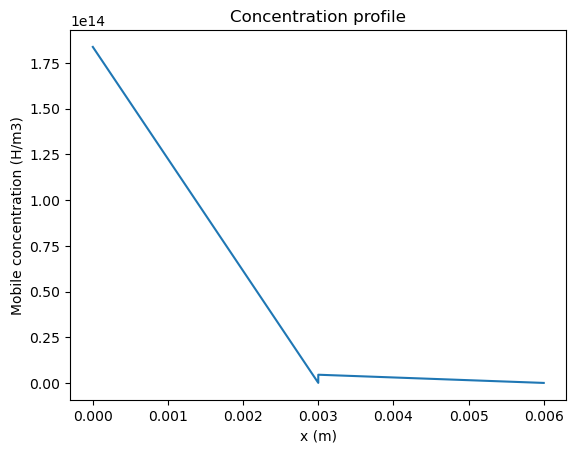

In [13]:
plot_concentration_profile(my_model, barrier_export, substrate_export)